Olá **Cientista**!

Bem vinda e bem vindo ao **mega desafio do Módulo 01**, neste desafio queremos que você aplique tudo que aprendeu no curso, analisando uma outra informação ~~referente a base de dados de [produção hospitalar](http://www2.datasus.gov.br/DATASUS/index.php?area=0202&id=11633&VObj=http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qi), seja número de internação, óbito, AIH ou taxa de mortalidade.~~ 

**P.S: Infelizmente o DataSUS está fora do ar por tempo indeterminado, para você não parar seu projeto, adicionamos no [GitHub](https://github.com/alura-cursos/agendamento-hospitalar/tree/main/dados) do curso, duas novas bases para você utilizar neste projeto (COVID-19 e Óbitos).**

Uma base é dos **casos de COVID-19 baixadas do projeto [BRASIL.IO](https://brasil.io/dataset/covid19/caso/)**, outra são os números de óbitos registrados no cartório civil desde 1970 retirado do **[Kaggle](https://www.kaggle.com/amandalk/registered-deaths-brazil)**.

Vocês podem escolher qualquer uma das duas bases de dados, a de COVID-19 é mais desafiadora e você vai precisar descompactar o arquivo por ser grande e entrar no site do Brasil.IO para entender todas as features presentes (No Brasil.IO tem diversas bases sobre COVID-19, estamos usando a chamada **Casos**). A base de óbito é mais simples e relativamente semelhate a utilizada no curso.

Algumas dicas para você mandar bem no desafio final, capriche nas análises, escreva suas conclusões e hipóteses (mesmo que resultado seja inconclusivo) e não esqueça de colocar um resumo dos pontos que julgar mais interessantes do seu projeto.



E para que o seu projeto tenha a oportunidade de ser avalido pelo Thiago G. Santos e Átila Iamarino, ao vivo na **live de revisão de projetos** submeta o link compartilhado do seu notebook [neste formulário](https://docs.google.com/forms/d/e/1FAIpQLSd1jemhvdo8sM6e-bgOryyZ2P3YuMO6E_mUQXabyBX_xhuZQQ/viewform?usp=sf_link) até dia 22/11 às 23h59.

Para facilitar a vida dos seus instrutores favoritos, no momento da correção, algumas dicas de como estruturar seu projeto:

- Como título do seu **Colab** coloque seu nome (Ex: Thiago_Gonçalves.ipynb)
- Crie um resumo das suas análises na parte superior do notebook
- Informe no resumo os dados que vc vai analisar (Ex: Finaceiros e Internações)

Qualquer dúvida não deixe de perguntar no Discord, compatilhe seu projeto nas redes sociais e crie um repositório no github, esse é o início do seu portifólio em Data Science.



Fique a vontade para utilizar esse notebook como template projeto.



## Resumo:

<h3>Como se compõe o contágio nas regiões do Brasil?</h3>

>- As regiões norte e centro oeste estão liderando em número de contágio por 100 mil habitantes.
>- A região centro oeste puxada pelo Distrito Federal, sofreu uma escalada de contágios após os primeiros meses de pandemia.
>- A escalada do centro oeste, junto a desaceleração do casos no norte puxada pela queda da velocidade de registro de casos no Amapá causou uma aproximação das duas regiões.

><img src="img/regioes.png">

<h3>Quais são os estados lideres em contágio por 100 mil habitantes de caracteristas?</h3>

>- Apesar de proporcinalmente os números indicarem que Roriama está em pior situação, com **mais de 10% da população da sua capital** infectada e liderança absoluta nos infectados por 100 mil habitantes, a **quantidade da população** torna a tragédia **muito pior** no Distrito Federal muito maior deixando mais do que o **dobro** de vítimas fatáis que o Amapá e Roraima Juntos. 
>- Apesar da grande melhora no Amapá, há indícios de uma nova aceleração de casos se formando na região.

<img src="img/mosaico_imagens_município.png">

<h3>Qual o comportamento do registro dos casos ?</h3>

>- Nos meses que a aceleração estava alta na região norte, pode se perceber uma diferença maior entre os dados do fim de semana e os de durante a semana, isso pode ter ocorrido pelo represamento dos resultados, note que em outubro com a nova aceleração dos casos o comportamento estar voltando. 

<img src="img/mosaico_imagens_meses.png">

<h3>Algum palpite para o problema na região norte ?</h3>

>- As cidades da região que tem mais infectados por 100 mil habitantes, são as fronteiriças.
>- houve um atraso no fechamento das fronteiras.
>>- Em 10/03/2020 a Guiana regista primeiro caso de COVID-19 
(**fonte:** [Wikipédia](https://pt.wikipedia.org/wiki/Pandemia_de_COVID-19_na_Guiana))
>>- Em 18/03/2020, ocorre o fechamento da fronteira de Pacaraima-RR com a Venezuela (**fonte:** [G1](https://g1.globo.com/rr/roraima/noticia/2020/03/18/fronteira-do-brasil-com-a-venezuela-e-fechada.ghtml))
>>- Em 19/03/2020, 9 dias depois do primeiro caso registrado na região, ocorre o fechamento das fronteiras com a Guiana,Guiana Francesa e Suriname. (**fontes:** [G1](https://g1.globo.com/rr/roraima/noticia/2020/03/19/brasil-fecha-fronteira-com-a-guiana.ghtml)/[Veja](https://veja.abril.com.br/mundo/brasil-fecha-fronteiras-com-8-paises-da-america-do-sul/))


<h3>Roraima</h3>

<img src="img/roraima.png"/>

<h3>Amapá</h3>

<img src="img/amapa.png"/>


#  Regiões por tempo

**Fonte:**[Brasil.IO - COVID-19 Casos](https://brasil.io/dataset/covid19/caso/)
<br>
Dados até 04/11/2020

##  Modificando dataframe

In [1]:

colunas = ['data',
 'uf',
 'municipio',
 'tipo_de_local',
 'confirmacoes',
 'mortes',
 'ordenacao',
 'ultimo',
 'pupolacao_estimada_2019',
 'pupolacao_estimada',
 'ibge_codigo',
 'confirmados_por_100k_hab',
 'mortes_por_confirmados']

regioes = {'1':'norte','2':'nordeste','3':'suldeste','4':'sul','5':'centrooeste'}

In [2]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import ticker
from matplotlib.patches import Ellipse
dados = pd.read_csv('base_covid/caso.csv',header=0,names=colunas)
dados.tipo_de_local = dados.tipo_de_local.map({'state':'estado','city':'cidade'})
dados['mes'] = dados.data.str[0:-3]
dados.data = pd.to_datetime(dados.data)
dados['cod_regiao'] = dados.ibge_codigo.apply(lambda x: str(x)[0:1])
dados['regiao'] = dados['cod_regiao'].map(regioes)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_palette('tab10')

In [4]:
df_slice_estados = dados.query("tipo_de_local == 'estado'").copy()
df_slice_estados.drop(['municipio','tipo_de_local'], axis=1, inplace=True)
df_slice_estados['cod_regiao'] = df_slice_estados.ibge_codigo.apply(lambda x: str(x)[0:1])
df_slice_estados['regiao'] = df_slice_estados['cod_regiao'].map(regioes)
df_slice_estados['mes'] =  df_slice_estados.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )
df_estados_agrupados_mes_uf_regiao = df_slice_estados.groupby(['mes','uf','regiao']).mean()['confirmados_por_100k_hab'].to_frame()
df_estados_agrupados_mes_uf_regiao.columns = ['media_'+df_estados_agrupados_mes_uf_regiao.columns[0]]
df_estados_agrupados_mes_uf_regiao.reset_index(inplace=True)

In [5]:
df_estados_agrupados_mes_uf_regiao['diferenca'] = df_estados_agrupados_mes_uf_regiao.sort_values(["uf",
                                                           'mes']).media_confirmados_por_100k_hab.diff()

df_estados_agrupados_mes_uf_regiao.loc[(df_estados_agrupados_mes_uf_regiao["diferenca"] < 0) & 
                          (df_estados_agrupados_mes_uf_regiao["mes"].isin(['2020-02','2020-03']))  , 'diferenca' ] = np.nan

df_estados_agrupados_mes_uf_regiao['aceleracao'] = df_estados_agrupados_mes_uf_regiao.sort_values(["uf",
                                                           'mes']).diferenca.diff()


In [6]:
_ = df_slice_estados[['data','uf','regiao','confirmados_por_100k_hab']]

_ = _.sort_values(['uf',"data"])

##_.groupby(['uf',"data"]).apply(lambda x: calc_diferenca(x))
_ = _.groupby(['regiao','uf',"data"]).mean()
df_aumento = _.groupby(level=0).apply(lambda x: round(x.diff(),2) )
df_media = _
_ = _.groupby(level=0).apply(lambda x: round(x.diff(),2) )
_ = _.groupby(level=0).apply(lambda x: round(x.diff(),2) )
df_aceleracao = _

df_diario_estados = pd.concat([df_aceleracao,df_aumento,df_media] , axis=1)
df_diario_estados.columns = ['aceleracao','aumento','media']
df_diario_estados = df_diario_estados.reset_index()
df_diario_estados['mes'] =  df_diario_estados.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )
df_diario_estados['dia_da_semana'] = df_diario_estados.data.dt.weekday.astype(str)
df_diario_estados['dia_da_semana'] = df_diario_estados['dia_da_semana'].map({'0':"Segunda",
                                        '1':"Terça",
                                        '2':"Quarta",
                                        '3':"Quinta",
                                        '4':"Sexta",
                                        '5':"Sábado",
                                        '6':"Domingo"} )

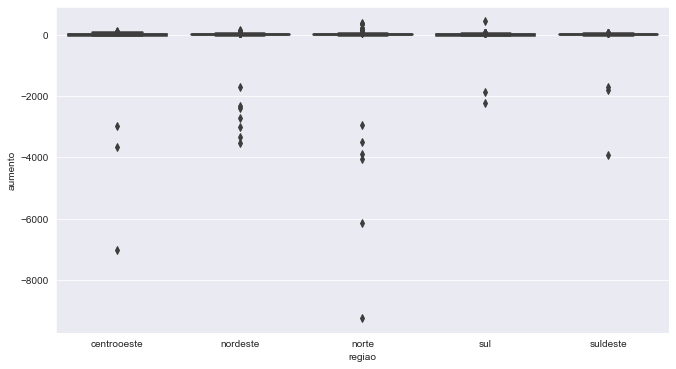

In [7]:
dt_inicio  = datetime.datetime(2020,1,1)
dt_fim = datetime.datetime(2020,10,31)
f, ax = plt.subplots(figsize=(11,6))

sns.boxplot(x="regiao", y="aumento",
            ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' "))

In [8]:
df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' and aumento < 0 ")

,regiao,uf,data,aceleracao,aumento,media,mes,dia_da_semana
243,centrooeste,GO,2020-03-12,-7045.60,-7035.78,0.04217,2020-03,Quinta
482,centrooeste,MS,2020-03-14,-3682.13,-3656.80,0.07119,2020-03,Sábado
718,centrooeste,MT,2020-03-20,-2982.57,-2976.27,0.02836,2020-03,Sexta
1186,nordeste,BA,2020-03-06,-2727.04,-2723.22,0.00670,2020-03,Sexta
1429,nordeste,CE,2020-03-16,-2427.85,-2405.23,0.09796,2020-03,Segunda
1664,nordeste,MA,2020-03-20,-3027.41,-3015.87,0.01406,2020-03,Sexta
2134,nordeste,PE,2020-03-12,-3333.15,-3324.76,0.02080,2020-03,Quinta
2373,nordeste,PI,2020-03-19,-1713.63,-1707.60,0.09142,2020-03,Quinta
2604,nordeste,RN,2020-03-12,-3553.98,-3529.63,0.02830,2020-03,Quinta
2816,nordeste,SE,2020-03-14,-2337.71,-2332.05,0.04313,2020-03,Sábado


Verificando possíveis reduções no número de infecções

In [9]:
dt_inicio  = datetime.datetime(2020,4,25)
dt_fim = datetime.datetime(2020,5,10)
df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) &
                 (df_diario_estados.uf == 'SC')]

,regiao,uf,data,aceleracao,aumento,media,mes,dia_da_semana
5166,sul,SC,2020-04-26,1.05,1.41,18.43502,2020-04,Domingo
5167,sul,SC,2020-04-27,0.51,1.92,20.35160,2020-04,Segunda
5168,sul,SC,2020-04-28,5.24,7.16,27.50775,2020-04,Terça
5169,sul,SC,2020-04-29,-5.92,1.24,28.74870,2020-04,Quarta
5170,sul,SC,2020-04-30,3.02,4.26,33.00930,2020-04,Quinta
5171,sul,SC,2020-05-01,-8.26,-4.00,29.01068,2020-05,Sexta
5172,sul,SC,2020-05-02,7.34,3.34,32.34746,2020-05,Sábado
5173,sul,SC,2020-05-03,-0.95,2.39,34.73284,2020-05,Domingo
5174,sul,SC,2020-05-04,-0.96,1.43,36.16683,2020-05,Segunda
5175,sul,SC,2020-05-05,0.94,2.37,38.53842,2020-05,Terça


Em santa catarina houve a única redução na média de infectados 

In [10]:
print("Removendo da lista, os dados que ficaram negativo por ser início de série")
df_diario_estados = df_diario_estados.query("aumento > -5")

Removendo da lista, os dados que ficaram negativo por ser início de série


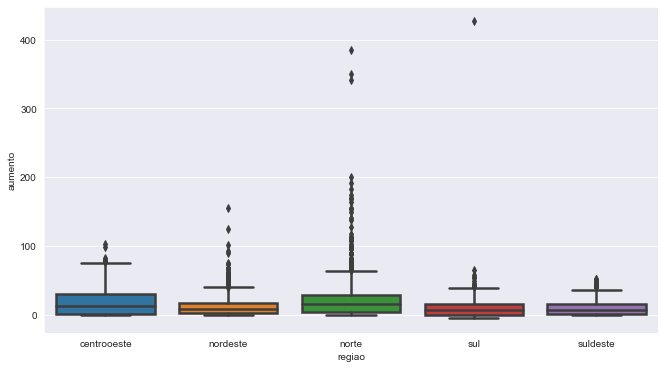

In [11]:
dt_inicio  = datetime.datetime(2020,1,1)
dt_fim = datetime.datetime(2020,10,31)
f, ax = plt.subplots(figsize=(11,6))

sns.boxplot(x="regiao", y="aumento",
            ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' "))

In [12]:
df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' and aumento > 200 ")

,regiao,uf,data,aceleracao,aumento,media,mes,dia_da_semana
3603,norte,AP,2020-06-22,319.80,350.67,2884.98247,2020-06,Segunda
4283,norte,RR,2020-06-22,330.18,340.95,1638.19887,2020-06,Segunda
4288,norte,RR,2020-06-27,173.64,200.10,2272.08994,2020-06,Sábado
4292,norte,RR,2020-07-01,303.87,384.99,2785.73024,2020-07,Quarta
5293,sul,SC,2020-08-31,419.90,426.24,2451.25062,2020-08,Segunda


Em alguns casos houve um represamento que criou esses outliers no aumento.

In [13]:
dt_inicio  = datetime.datetime(2020,6,20)
dt_fim = datetime.datetime(2020,7,5)
df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) &
                 (df_diario_estados.uf == 'RR')]

,regiao,uf,data,aceleracao,aumento,media,mes,dia_da_semana
4282,norte,RR,2020-06-21,-2.38,10.77,1297.25071,2020-06,Domingo
4283,norte,RR,2020-06-22,330.18,340.95,1638.19887,2020-06,Segunda
4284,norte,RR,2020-06-23,-267.60,73.35,1711.55342,2020-06,Terça
4285,norte,RR,2020-06-24,96.02,169.37,1880.91847,2020-06,Quarta
4286,norte,RR,2020-06-25,-4.76,164.61,2045.53052,2020-06,Quinta
4287,norte,RR,2020-06-26,-138.15,26.46,2071.98886,2020-06,Sexta
4288,norte,RR,2020-06-27,173.64,200.10,2272.08994,2020-06,Sábado
4289,norte,RR,2020-06-28,-181.40,18.70,2290.78505,2020-06,Domingo
4290,norte,RR,2020-06-29,10.13,28.83,2319.61989,2020-06,Segunda
4291,norte,RR,2020-06-30,52.29,81.12,2400.73766,2020-06,Terça


identificação do represamento 

In [14]:
print('Optei por esxcluir os maiores represamentos para facilitar a visualização')
df_diario_estados = df_diario_estados.query("aumento < 200")

Optei por esxcluir os maiores represamentos para facilitar a visualização


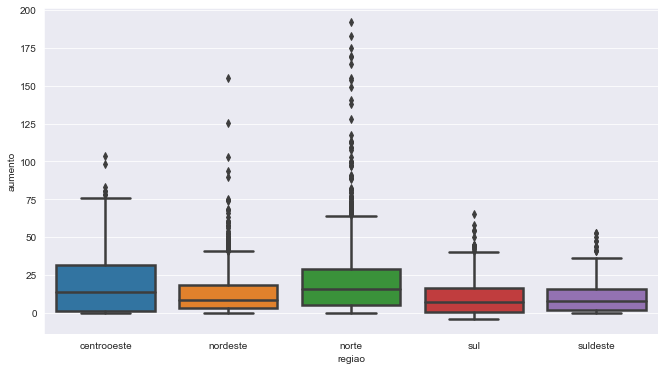

In [15]:
dt_inicio  = datetime.datetime(2020,1,1)
dt_fim = datetime.datetime(2020,10,31)
f, ax = plt.subplots(figsize=(11,6))

sns.boxplot(x="regiao", y="aumento",
            ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' "))

## Análises

###   Por Regiões

####  Comportamento ao longo do tempo

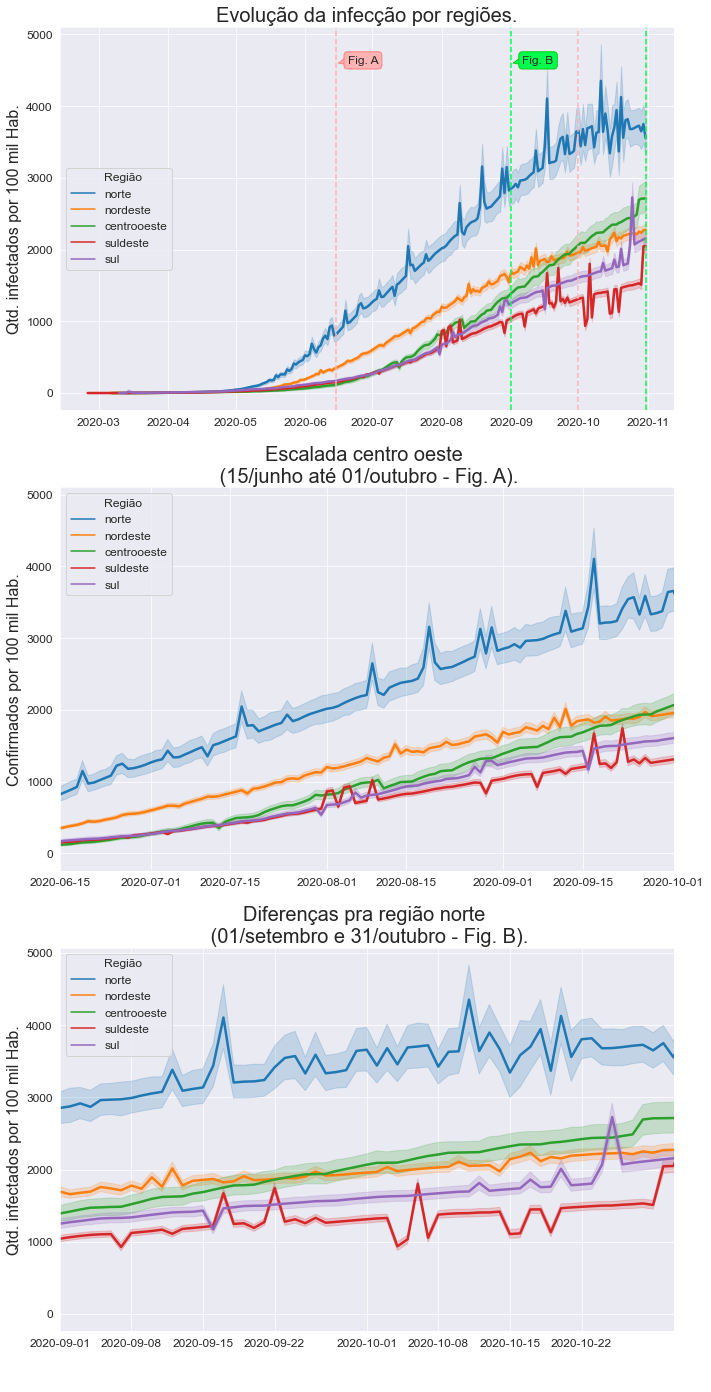

In [16]:
dt_ini_figa = datetime.datetime(2020,6,15)
dt_fim_figa =datetime.datetime(2020,10,1)
dt_ini_figb = datetime.datetime(2020,9,1) 
dt_fim_figb =datetime.datetime(2020,10,31)
el = Ellipse((2, -1), 0.5, 0.5)

f, ax = plt.subplots(3,1,figsize=(11,24))


sns.lineplot(x="data", y="confirmados_por_100k_hab",
             hue="regiao",ax = ax[0],linewidth=2.5,
             data=dados.query("mes != '2020-11'"))
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax[0].legend(by_label.values(),listaRotulos,loc=6, fontsize=12)
ax[0].set_xlabel(" \n ", fontsize=16)
ax[0].set_ylabel("Qtd. infectados por 100 mil Hab.", fontsize=16)
ax[0].tick_params(axis='y', labelsize=12 )
ax[0].tick_params(axis='x', labelsize=12 )
ax[0].axvline(dt_ini_figa, color = (1.0, 0.7, 0.7), linestyle='--')
ax[0].axvline(dt_fim_figa, color = (1.0, 0.7, 0.7), linestyle='--')
posicao_yanotacao = ax[0].get_ylim()[-1] *0.9
ax[0].annotate('Fig. A', xy=(dt_ini_figa,posicao_yanotacao),
               xytext=(dt_ini_figa + datetime.timedelta(days=5) ,posicao_yanotacao),
               fontsize=12,
                bbox=dict(boxstyle="round",
                            fc=(1.0, 0.7, 0.7),
                            ec=(1., .5, .5)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
              )

ax[0].axvline(dt_ini_figb, color = (0, 1.0, 0.3), linestyle='--')
ax[0].axvline(dt_fim_figb, color = (0, 1.0, 0.3), linestyle='--')
ax[0].annotate('Fig. B', xy=(dt_ini_figb,posicao_yanotacao),
               fontsize=12,
              xytext=(dt_ini_figb + datetime.timedelta(days=5),posicao_yanotacao),
                 bbox=dict(boxstyle="round",
                            fc=(0, 1.0, 0.3),
                            ec=(0, .8, 0.1)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(0, 1.0, 0.3), ec=(0, .8, 0.1),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
              )

_ =ax[0].set_title('Evolução da infecção por regiões.', fontsize=20, pad=5)



sns.lineplot(x="data", y="confirmados_por_100k_hab",
             hue="regiao",ax = ax[1],linewidth=2.5,
             data=dados)
handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax[1].set_xlim(dt_ini_figa, dt_fim_figa)
ax[1].legend(by_label.values(),listaRotulos,loc=2, fontsize=12)
ax[1].set_xlabel(" \n ", fontsize=16)
ax[1].set_ylabel("Confirmados por 100 mil Hab.", fontsize=16)
ax[1].tick_params(axis='y', labelsize=12 )
ax[1].tick_params(axis='x', labelsize=12 )
ax[1].set_title('Escalada centro oeste \n (15/junho até 01/outubro - Fig. A).', fontsize=20, pad=5)




sns.lineplot(x="data", y="confirmados_por_100k_hab",
             hue="regiao",ax = ax[2],linewidth=2.5,
             data=dados)
handles, labels = ax[2].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax[2].set_xlim(dt_ini_figb,dt_fim_figb)
ax[2].legend(by_label.values(),listaRotulos,loc=2, fontsize=12)
ax[2].set_xlabel(" \n ", fontsize=16)
ax[2].set_ylabel("Qtd. infectados por 100 mil Hab.", fontsize=16)
ax[2].tick_params(axis='y', labelsize=12 )
ax[2].tick_params(axis='x', labelsize=12 )
_=ax[2].set_title('Diferenças pra região norte \n (01/setembro e 31/outubro - Fig. B).', fontsize=20, pad=5)


f.savefig("img/escalada.png",bbox_inches='tight')

Com relação aos acumulado de casos por 100 mil habitantes é possível notar uma escalada da região Centro Oeste que passou da menor em numero de casos, em 15 de junho, para segunda maior em pouco mais de 3 meses, conforme demonstrado na **Figura A (15/junho até 01/outubro)**. Fica claro também uma desaceleração da região norte, a partir de 01/setembro, havendo uma aproximação entre as duas regiões no número de casos demonstrado na **Figura B (01/setembro e 31/outubro)**.

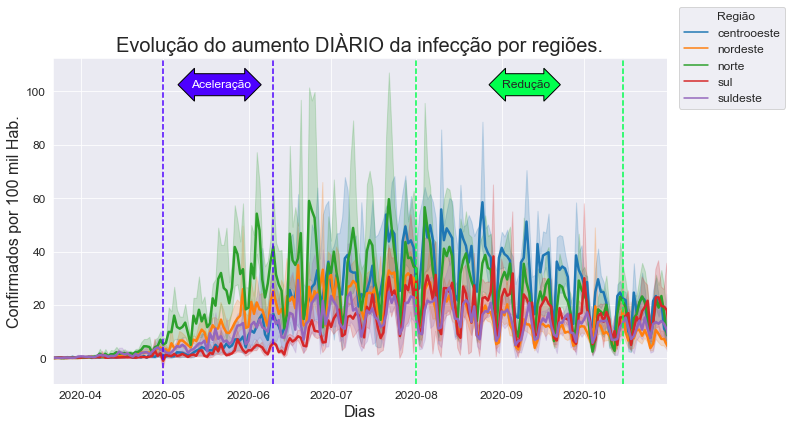

In [17]:
dt_inicio  = datetime.datetime(2020,3,22)
dt_fim = datetime.datetime(2020,10,31)
dt_ini_figc  = datetime.datetime(2020,8,1)
dt_fim_figc = datetime.datetime(2020,10,15)
dt_ini_figd  = datetime.datetime(2020,5,1)
dt_fim_figd = datetime.datetime(2020,6,10)


f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="aumento",
             hue="regiao",ax = ax,linewidth=2.5,
             data=df_diario_estados)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos,loc=6, fontsize=12 , bbox_to_anchor=(1.01, 1))
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("Confirmados por 100 mil Hab.", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )
ax.axvline(dt_ini_figc, color = (.0,1.0,.3), linestyle='--')
ax.axvline(dt_fim_figc, color = (.0,1.0,.3), linestyle='--')
ax.annotate('Redução',
            xy=(dt_ini_figc + datetime.timedelta(days=31) ,
                           posicao_yanotacao),
            bbox=dict(boxstyle="DArrow",pad=0.5,
                            fc=(0, 1.0, 0.3),
                            ec='k'),
            fontsize=12)
ax.axvline(dt_ini_figd, color = (.3,0.0,1.0), linestyle='--')
ax.axvline(dt_fim_figd, color = (.3,.0,1.0), linestyle='--')
ax.annotate("Aceleração", color=(1.0,1.0,1.0),
            xy=(dt_ini_figd + datetime.timedelta(days=10) ,
                posicao_yanotacao),
            bbox=dict(boxstyle="DArrow", pad=0.5,
                            fc=(.3,.0,1.0),
                            ec='k'),            
            fontsize=12)

_ =ax.set_title('Evolução do aumento DIÀRIO da infecção por regiões.', fontsize=20)


<h6>Há uma redução do aumento de infectados entre agosto e outubro em todas as regiões. um distanciamento em Maio da região norte taxa de aumento, e uma troca na liderança com o centro oeste  a partir de julho. </h6>

#### Contribuição de cada região para o Total de casos

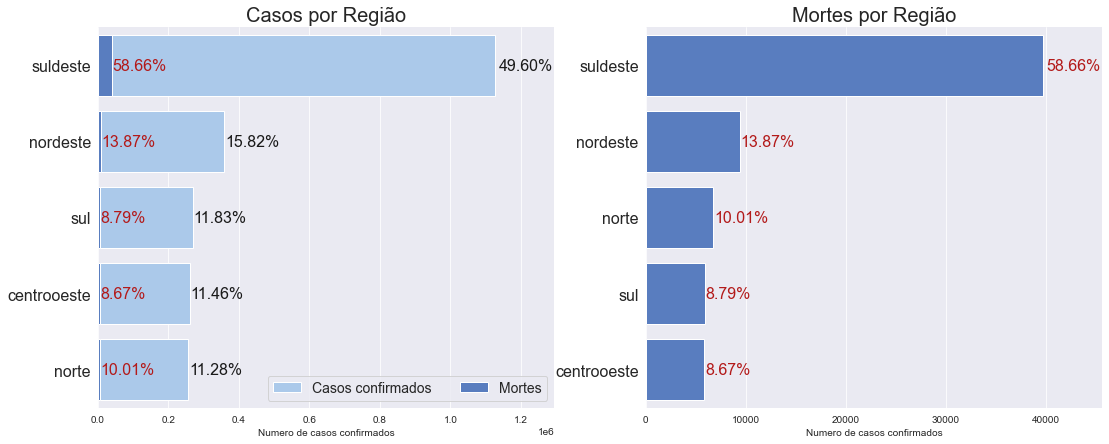

In [18]:
_ = df_slice_estados.groupby(['regiao']).max()[['confirmacoes','mortes']].reset_index()


_["proporcao_casos"] = _["confirmacoes"]/_.sum()['confirmacoes']
_["proporcao_mortes"] = _["mortes"]/_.sum()['mortes']
_.sort_values('proporcao_casos', ascending=False,inplace=True)

f, ax = plt.subplots(1,2,figsize=(18, 7))

sns.set_color_codes("pastel")
g = sns.barplot(x="confirmacoes", y="regiao", data=_,
            label="Casos confirmados", color="b", ax=ax[0])
sns.set_color_codes("muted")
sns.barplot(x="mortes", y="regiao", data=_,
            label="Mortes", color="b", ax=ax[0])

ax[0].legend(ncol=2, loc="lower right", frameon=True, fontsize=14)
ax[0].tick_params(axis='y', labelsize=16 )
ax[0].set(xlim=(0, _['confirmacoes'].max()*1.15), ylabel="",
       xlabel="Numero de casos confirmados")
ax[0].set_title("Casos por Região", fontsize=20)
sns.despine(left=True, bottom=True)

for i,r in enumerate(_.confirmacoes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_casos.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color='k', va="center", fontsize=16)
for i,r in enumerate(_.mortes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_mortes.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center", fontsize=16)
_.sort_values('proporcao_mortes', ascending=False,inplace=True)   

sns.set_color_codes("muted")
sns.barplot(x="mortes", y="regiao", data=_,
            color="b", ax=ax[1])

ax[1].tick_params(axis='y', labelsize=16 )
ax[1].set(xlim=(0, _['mortes'].max()*1.15), ylabel="",
       xlabel="Numero de casos confirmados")
ax[1].set_title("Mortes por Região", fontsize=20)
sns.despine(left=True, bottom=True)


for i,r in enumerate(_.mortes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_mortes.to_list()[i]
    ax[1].text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center", fontsize=16)
f.savefig("img/casos_por_REG.png",bbox_inches='tight')

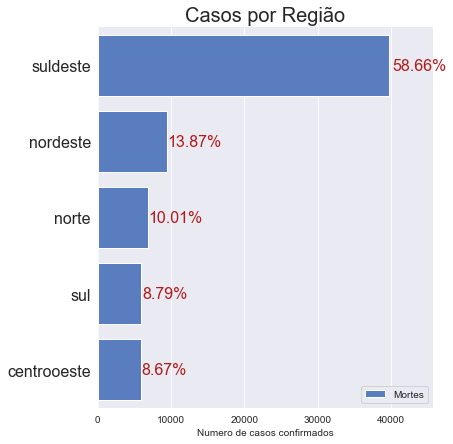

In [19]:
f, ax = plt.subplots(figsize=(6, 7))


sns.set_color_codes("muted")
sns.barplot(x="mortes", y="regiao", data=_,
            label="Mortes", color="b", ax=ax)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.tick_params(axis='y', labelsize=16 )
ax.set(xlim=(0, _['mortes'].max()*1.15), ylabel="",
       xlabel="Numero de casos confirmados")
ax.set_title("Casos por Região", fontsize=20)
sns.despine(left=True, bottom=True)

for i,r in enumerate(_.mortes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_mortes.to_list()[i]
    ax.text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center", fontsize=16)

#### Sazonalidade da confirmação  dos casos

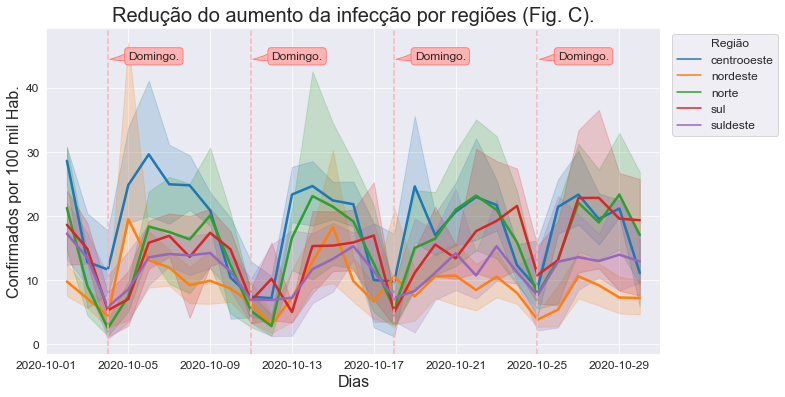

In [20]:
dt_inicio  = datetime.datetime(2020,10,1)
dt_fim = datetime.datetime(2020,10,31)

domingos = df_diario_estados[(dt_inicio < df_diario_estados.data) &
                             (df_diario_estados.data < dt_fim)].query("dia_da_semana == 'Domingo' and uf == 'RR'"
                                                           )['data'].to_list()


f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="aumento",
             hue="regiao",ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11'"))


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("Confirmados por 100 mil Hab.", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )
_ =ax.set_title('Redução do aumento da infecção por regiões (Fig. C).', fontsize=20)
for domingo in domingos:
    ax.axvline(domingo, ymax=250, color = (1.0, 0.7, 0.7), linestyle='--')
    ax.annotate('Domingo.', xy=(domingo,posicao_yanotacao), fontsize=12, 
              xytext=(domingo+ datetime.timedelta(days=1),posicao_yanotacao), #arrowprops=dict(facecolor='k')
               bbox=dict(boxstyle="round",
                            fc=(1.0, 0.7, 0.7),
                            ec=(1., .5, .5)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
               )

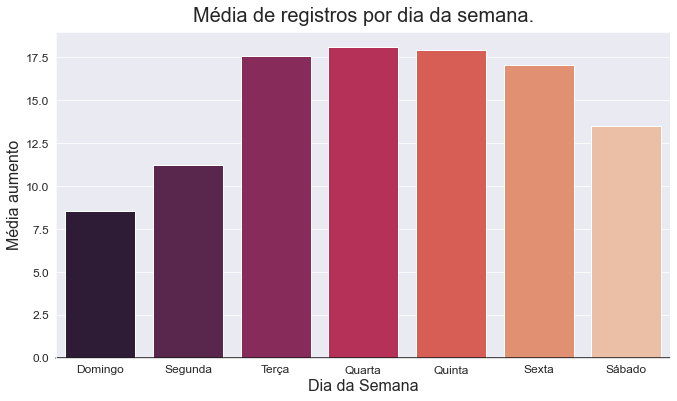

In [21]:

f,ax = plt.subplots(figsize=(11, 6))

x = df_diario_estados.groupby('dia_da_semana').mean()['aumento'].index.to_numpy()
y1 = df_diario_estados.groupby('dia_da_semana').mean()['aumento'].to_numpy()
sns.barplot(x=x, y=y1, palette="rocket", ax=ax ,order=["Domingo","Segunda","Terça","Quarta",'Quinta','Sexta', 'Sábado'])
ax.axhline(0, color="k", clip_on=False)
ax.set_xlabel("Dia da Semana", fontsize=16)
ax.set_ylabel("Média aumento", fontsize=16)
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )
_ =ax.set_title('Média de registros por dia da semana.', fontsize=20, pad=10)

### Por estados

####  Contribuição de cada estado para o total de casos (excluindo São Paulo)

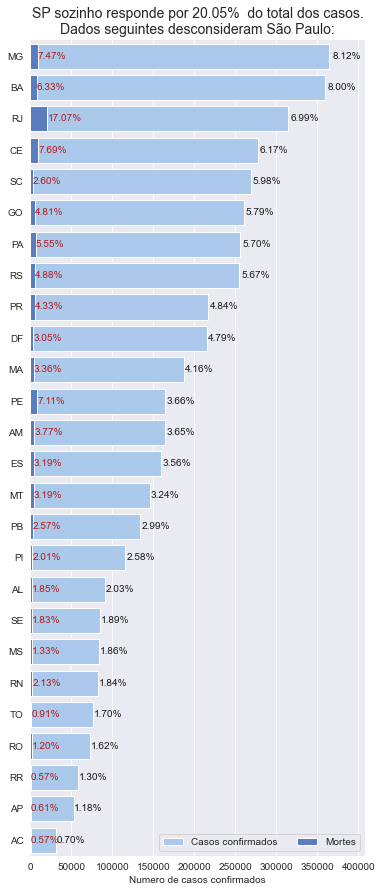

In [22]:
_ = df_slice_estados.groupby(['regiao','uf']).max()[['confirmacoes','mortes']].reset_index()

estado_max = _['uf'][_['confirmacoes'].idxmax()],_['confirmacoes'].max()
percent = estado_max[1]/_.sum()['confirmacoes']

_sem_sao_paulo = _.query("uf != 'SP'").copy()
_sem_sao_paulo["proporcao_casos"] = _sem_sao_paulo["confirmacoes"]/_sem_sao_paulo.sum()['confirmacoes']
_sem_sao_paulo["proporcao_mortes"] = _sem_sao_paulo["mortes"]/_sem_sao_paulo.sum()['mortes']
_sem_sao_paulo.sort_values('proporcao_casos', ascending=False,inplace=True)


f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
g = sns.barplot(x="confirmacoes", y="uf", data=_sem_sao_paulo,
            label="Casos confirmados", color="b")
sns.set_color_codes("muted")
sns.barplot(x="mortes", y="uf", data=_sem_sao_paulo,
            label="Mortes", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, _sem_sao_paulo['confirmacoes'].max()*1.12), ylabel="",
       xlabel="Numero de casos confirmados" )
ax.set_title('{} sozinho responde por {:.2%}  do total dos casos.\n\
Dados seguintes desconsideram São Paulo:'.format(estado_max[0],
             estado_max[1]/_.sum()['confirmacoes']), fontsize=14)
sns.despine(left=True, bottom=True)

for i,r in enumerate(_sem_sao_paulo.confirmacoes.to_list()):
    x = r*1.01
    y = i
    v = _sem_sao_paulo.proporcao_casos.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color='k', va="center")
for i,r in enumerate(_sem_sao_paulo.mortes.to_list()):
    x = r*1.01
    y = i
    v = _sem_sao_paulo.proporcao_mortes.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center")



####  Análise das tendências por médias móveis (incluindo São Paulo)

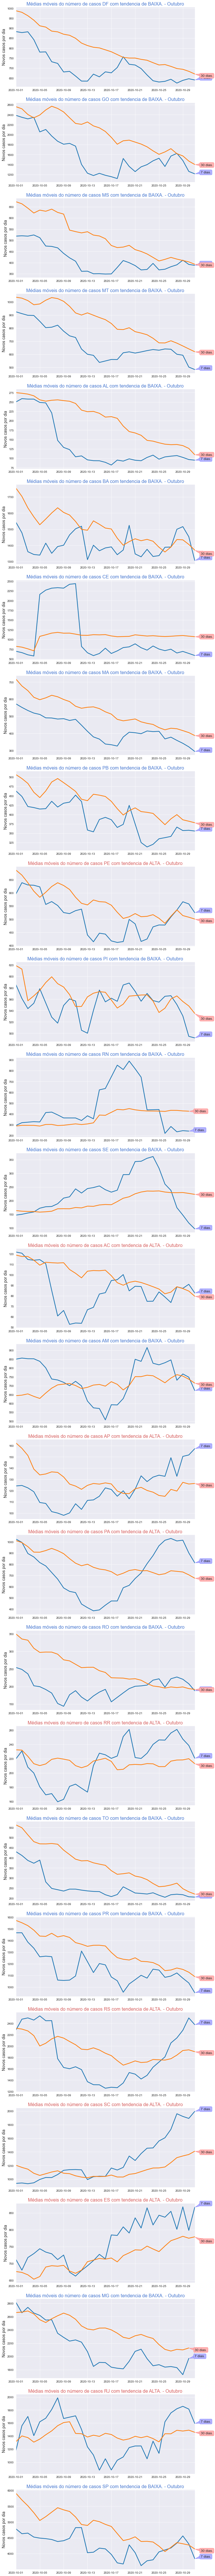

In [23]:
dt_inicio = datetime.datetime(2020,10,1)
dt_fim = datetime.datetime(2020,10,31)

lista_series = []
for UF in _.uf:
    df_estado = df_slice_estados.query("uf =='"+UF+"'").sort_values(['uf','data']).confirmacoes.diff()
    lista_series.append(df_estado)
df_slice_estados['novos_casos']= pd.concat(lista_series)
sr_MM_7 = df_slice_estados.sort_values(['uf','data']).novos_casos.rolling(7).mean()
sr_MM_30 = df_slice_estados.sort_values(['uf','data']).novos_casos.rolling(30).mean()
df_RJ = df_slice_estados.sort_values(['uf','data']).copy()
df_RJ['media_7_dias'] = sr_MM_7
df_RJ['media_30_dias'] = sr_MM_30

qtd = len(_.uf)
f, ax = plt.subplots(qtd,1,figsize=(11,6*qtd))
for i,UF in enumerate(_.uf):
    data = df_RJ.query("uf =='"+UF+"'")
    data = data[(data.data>=dt_inicio) &( data.data<=dt_fim)]
    x_position = data['data'].to_list()[-1]
    y_7dias = data['media_7_dias'].to_list()[-1]
    y_14dias = data['media_30_dias'].to_list()[-1]
    sns.lineplot(x="data", y="media_7_dias", palette="tab10",
             linewidth=2.5,
             data=data, ax=ax[i])
    sns.lineplot(x="data", y="media_30_dias",              linewidth=2.5,
             data=data, ax=ax[i])
    if y_7dias > y_14dias:
        tendencia = "ALTA."
        cor = 'r'
    else:
        tendencia = "BAIXA."
        cor = 'b'
    ax[i].set_title("Médias móveis do número de casos "+UF+" com tendencia de "+tendencia+" - Outubro",fontsize=16, color=cor)
    ax[i].set_xlim(dt_inicio,dt_fim)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Novos casos por dia", fontsize=14)
    ax[i].annotate('7 dias.', xy=(x_position,y_7dias), fontsize=12, 
              xytext=(x_position + datetime.timedelta(days=1),y_7dias*1.01), #arrowprops=dict(facecolor='k')
               bbox=dict(boxstyle="round",
                            fc=(0.7, 0.7, 1),
                            ec=(.5, .5, 1)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(0.7, 0.7, 1), ec=(.5, .5, 1),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
               )
    
    ax[i].annotate('30 dias.', xy=(x_position,y_14dias), fontsize=12, 
              xytext=(x_position + datetime.timedelta(days=1),y_14dias*.98), #arrowprops=dict(facecolor='k')
               bbox=dict(boxstyle="round",
                            fc=(1.0, 0.7, 0.7),
                            ec=(1., .5, .5)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
               )

#### Contribuição de cada estado para o total mortes (excluindo São Paulo)

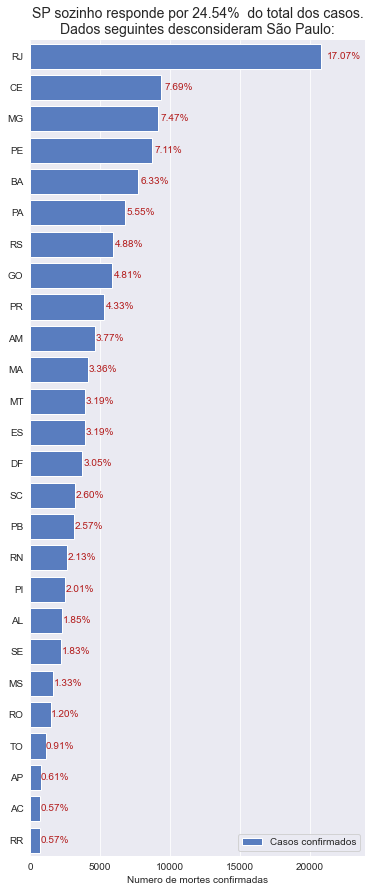

In [24]:
_ = df_slice_estados.groupby(['regiao','uf']).max()[['confirmacoes','mortes']].reset_index()

estado_max = _['uf'][_['mortes'].idxmax()],_['mortes'].max()
percent =  estado_max[1]/_.sum()['mortes']
#_ = _.groupby("regiao").sum()

_ = _.query("uf != 'SP'")
_["proporcao_casos"] = _["confirmacoes"]/_.sum()['confirmacoes']
_["proporcao_mortes"] = _["mortes"]/_.sum()['mortes']
_.sort_values('proporcao_mortes', ascending=False,inplace=True)


f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("muted")
g = sns.barplot(x="mortes", y="uf", data=_,
            label="Casos confirmados", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, _['mortes'].max()*1.15), ylabel="",
       xlabel="Numero de mortes confirmadas")
ax.set_title('{} sozinho responde por {:.2%}  do total dos casos.\n\
Dados seguintes desconsideram São Paulo:'.format(estado_max[0],
             percent), fontsize=14)
sns.despine(left=True, bottom=True)


for i,r in enumerate(_.mortes.to_list()):
    x = r*1.02
    y = i
    v = _.proporcao_mortes.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center")


#### Top 5 contágio por 100 mil habitantes

Região  Média de casos confirmados por 100 mil habitantes
mes     uf                                                                
2020-11 RR        norte                                            9157.63
        DF  centrooeste                                            7010.49
        AP        norte                                            6110.85
        TO        norte                                            4771.17
        MT  centrooeste                                            4099.47

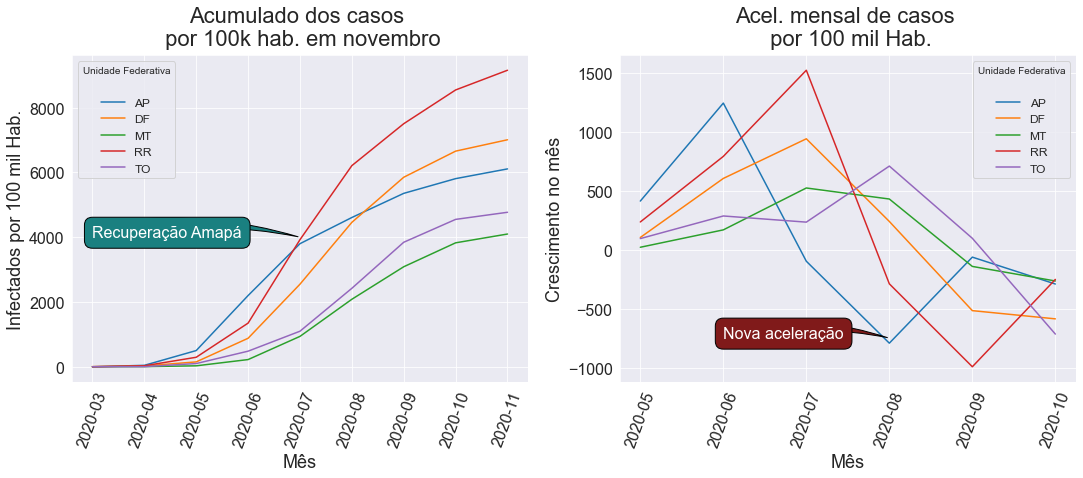

In [25]:
_=df_estados_agrupados_mes_uf_regiao.query("mes == '2020-11'").sort_values('media_confirmados_por_100k_hab',
                                                                                    ascending=False).round(2).head()
_.index = [_.mes,_.uf]

lista_uf = _.uf.to_list()
f, ax = plt.subplots(1,2,figsize=(18,6))

sns.lineplot(x="mes", y="media_confirmados_por_100k_hab",
             hue="uf",ax = ax[0],
             data=df_estados_agrupados_mes_uf_regiao[df_estados_agrupados_mes_uf_regiao["uf"].isin(lista_uf)])
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax[0].legend(by_label.values(),listaRotulos,loc=2, fontsize=12, title="Unidade Federativa")
ax[0].set_xlabel("Mês", fontsize=18)
ax[0].set_ylabel("Infectados por 100 mil Hab.", fontsize=18)
ax[0].set_title("Acumulado dos casos \n por 100k hab. em novembro", fontsize=22,pad=10)
ax[0].tick_params(axis='y', labelsize=16 )
ax[0].tick_params(axis='x', labelsize=16, labelrotation =70.0)

ax[0].annotate('Recuperação Amapá', xy=('2020-07',4000), c=(1,1,1),
               fontsize=16,
              xytext=('2020-03',4000),
                 bbox=dict(boxstyle="round", pad=0.5,
                            fc=(0.1, 0.5, 0.5),
                            ec=(.0, .0, .0)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(0.1, 0.5, 0.5), ec=(.0,.0, .0),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
              )




sns.lineplot(x="mes", y="aceleracao",
             hue="uf",ax = ax[1],
             data=df_estados_agrupados_mes_uf_regiao.query("mes != '2020-11'").loc[df_estados_agrupados_mes_uf_regiao["uf"].isin(lista_uf)])
handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax[1].legend(by_label.values(),listaRotulos,loc=1, fontsize=12, title="Unidade Federativa")
ax[1].set_xlabel("Mês", fontsize=18)
ax[1].set_ylabel("Crescimento no mês", fontsize=18)
ax[1].set_title('Acel. mensal de casos \n por 100 mil Hab.', fontsize=22,pad=10)
ax[1].tick_params(axis='y', labelsize=16 )
ax[1].tick_params(axis='x', labelsize=16 , labelrotation =70.0)

ax[1].annotate('Nova aceleração', xy=('2020-08',-750), c=(1,1,1),
               fontsize=16,
              xytext=('2020-06',-750),
                 bbox=dict(boxstyle="round", pad=0.5,
                            fc=(0.5, 0.1, .1),
                            ec=(.0, .0, .0)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(0.5, 0.1, .1), ec=(.0,.0, .0),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
              )
f.savefig("img/acumulado.png",bbox_inches='tight')

_ = _[['regiao','media_confirmados_por_100k_hab']]
_.columns = ['Região',"Média de casos confirmados por 100 mil habitantes"]
_

O estado do Amapá, após julho, conseguiu reagir bem e reduzir a curva de contágio por 100 mil habitantes, deixando de ser o pior em número de casos. porém já apresenta nova aceleração após agosto.

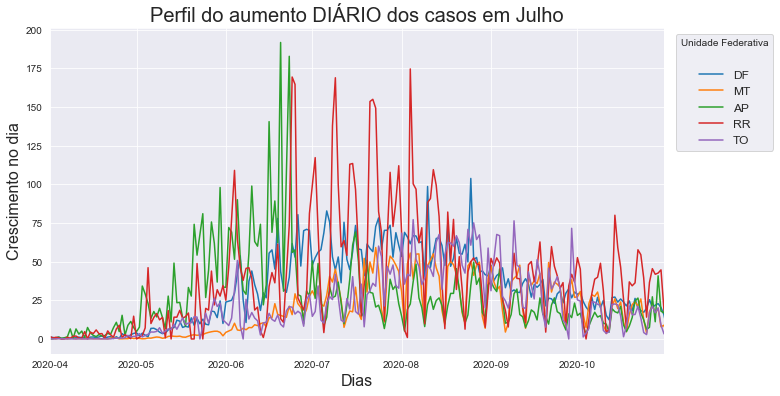

In [26]:
dt_inicio = datetime.datetime(2020,4,1)
dt_fim = datetime.datetime(2020,10,31)


f, ax = plt.subplots(figsize=(11,6))


sns.lineplot(x="data", y="aumento",
             hue="uf",ax = ax,
             data=df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          title="Unidade Federativa",
          bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_xlabel("Dias", fontsize=16)
_ = df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)]

ax.set_ylabel("Crescimento no dia", fontsize=16)
ax.set_title('Perfil do aumento DIÁRIO dos casos em Julho', fontsize=20)
_=ax.set_xlim(dt_inicio,dt_fim)


 É Possivel ver o represamento na confirmação dos casos no AMAPÁ e RORAIMA, ao notar a disparidade dos casos registrados no fim de semana para os registrados no meio da semana, é possível notar também que a amplitude diminue quando a pandemia diminui (Julho até Setembro) e aumenta quando a aceleração aumenta (outubro), o que pode ser justificado pela baixa capacidade de testagem frente a velocidade de contágio.
 as próximas imagens ilustam a redução da amplitude e a recuperação seguinte.

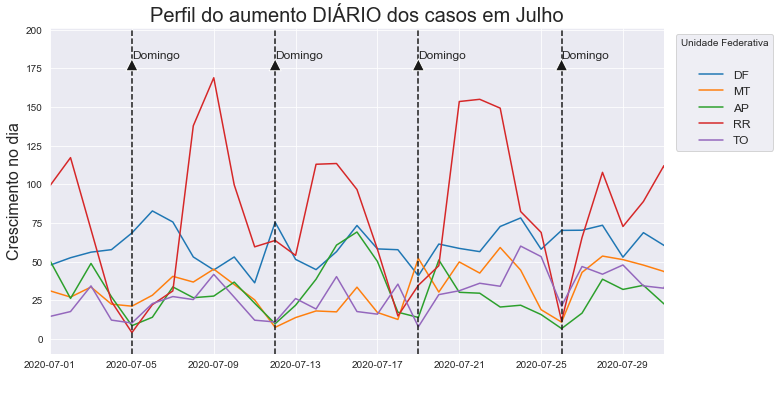

In [27]:
dt_inicio = datetime.datetime(2020,7,1)
dt_fim = datetime.datetime(2020,7,31)

domingos = df_diario_estados[(dt_inicio < df_diario_estados.data) &
                             (df_diario_estados.data < dt_fim)].query("dia_da_semana == 'Domingo' and uf == 'RR'"
                                                           )['data'].to_list()

f, ax = plt.subplots(figsize=(11,6))


sns.lineplot(x="data", y="aumento",
             hue="uf",ax = ax,
             data=df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          title="Unidade Federativa",
          bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_xlabel(" ", fontsize=16)
_ = df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)]
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.set_ylabel("Crescimento no dia", fontsize=16)
ax.set_title('Perfil do aumento DIÁRIO dos casos em Julho', fontsize=20)
ax.set_xlim(dt_inicio,dt_fim)

for domingo in domingos:
    ax.axvline(domingo, ymax=250, color = 'k', linestyle='--')
    ax.annotate('Domingo', xy=(domingo,posicao_yanotacao), fontsize=12, 
              xytext=(domingo,posicao_yanotacao), arrowprops=dict(facecolor='k'))
f.savefig("img/julho.png",bbox_inches='tight') 

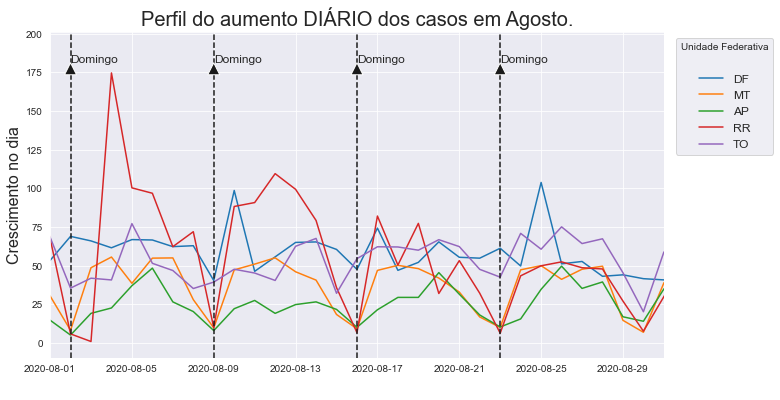

In [28]:
dt_inicio = datetime.datetime(2020,8,1)
dt_fim = datetime.datetime(2020,8,31)

domingos = df_diario_estados[(dt_inicio < df_diario_estados.data) &
                             (df_diario_estados.data < dt_fim)].query("dia_da_semana == 'Domingo' and uf == 'RR'"
                                                           )['data'].to_list()

f, ax = plt.subplots(figsize=(11,6))


sns.lineplot(x="data", y="aumento",
             hue="uf",ax = ax,
             data=df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          title="Unidade Federativa",
          bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel(" ", fontsize=16)

ax.set_ylabel("Crescimento no dia", fontsize=16)
ax.set_title('Perfil do aumento DIÁRIO dos casos em Agosto.', fontsize=20)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
for domingo in domingos[:-1]:
    ax.axvline(domingo, ymax=250, color = 'k', linestyle='--')
    ax.annotate('Domingo', xy=(domingo,posicao_yanotacao), fontsize=12, 
              xytext=(domingo,posicao_yanotacao), arrowprops=dict(facecolor='k')) 
f.savefig("img/agosto.png",bbox_inches='tight')

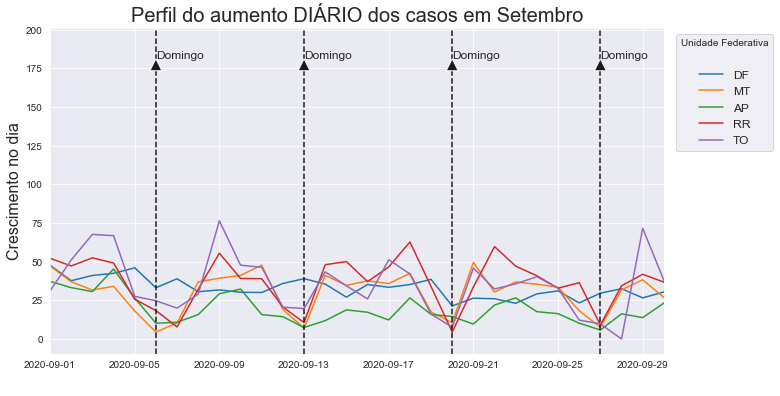

In [29]:
dt_inicio = datetime.datetime(2020,9,1)
dt_fim = datetime.datetime(2020,9,30)

domingos = df_diario_estados[(dt_inicio < df_diario_estados.data) &
                             (df_diario_estados.data < dt_fim)].query("dia_da_semana == 'Domingo' and uf == 'RR'"
                                                           )['data'].to_list()

f, ax = plt.subplots(figsize=(11,6))


sns.lineplot(x="data", y="aumento",
             hue="uf",ax = ax,
             data=df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          title="Unidade Federativa",
          bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel(" ", fontsize=16)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.set_ylabel("Crescimento no dia", fontsize=16)
ax.set_title('Perfil do aumento DIÁRIO dos casos em Setembro', fontsize=20)
ax.set_xlim(dt_inicio,dt_fim)

for domingo in domingos:
    ax.axvline(domingo, ymax=250, color = 'k', linestyle='--')
    ax.annotate('Domingo', xy=(domingo,posicao_yanotacao), fontsize=12, 
              xytext=(domingo,posicao_yanotacao), arrowprops=dict(facecolor='k'))
f.savefig("img/setembro.png",bbox_inches='tight')

<h6>É possivel notar que o número de casos por 100 mil habitantes cresce mais em RR do que no Distrito Federa(DF), e a forte reversão desta tendencia no AP. </h6>

In [ ]:
dt_inicio = datetime.datetime(2020,10,1)
dt_fim = datetime.datetime(2020,10,31)

domingos = df_diario_estados[(dt_inicio < df_diario_estados.data) &
                             (df_diario_estados.data < dt_fim)].query("dia_da_semana == 'Domingo' and uf == 'RR'"
                                                           )['data'].to_list()

f, ax = plt.subplots(figsize=(11,6))


sns.lineplot(x="data", y="aumento",
             hue="uf",ax = ax,
             data=df_diario_estados.loc[df_diario_estados["uf"].isin(lista_uf)])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = ""
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          title="Unidade Federativa",
          bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel(" ", fontsize=16)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.set_ylabel("Crescimento no dia", fontsize=16)
ax.set_title('Perfil do aumento DIÁRIO dos casos em Outubro', fontsize=20)
ax.set_xlim(dt_inicio,dt_fim)

for domingo in domingos:
    ax.axvline(domingo, ymax=250, color = 'k', linestyle='--')
    ax.annotate('Domingo', xy=(domingo,posicao_yanotacao), fontsize=12, 
              xytext=(domingo,posicao_yanotacao), arrowprops=dict(facecolor='k'))
f.savefig("img/outubro.png",bbox_inches='tight')

####  Caracterista importantes dos TOP 3

In [ ]:
_=df_estados_agrupados_mes_uf_regiao[(df_estados_agrupados_mes_uf_regiao.uf.isin(["DF",
                                                     "RR"]))].copy()
_["distancia"] = _["media_confirmados_por_100k_hab"].diff()


_.index = _.mes

_ = _.query("uf == 'RR'")
RR_DF = _
_=df_estados_agrupados_mes_uf_regiao[(df_estados_agrupados_mes_uf_regiao.uf.isin(["DF",
                                                      "AP"]))].copy()
_["distancia"] = (_["media_confirmados_por_100k_hab"].diff())*-1
_.index = _.mes
_ = _.query("uf == 'DF'")
AP_DF = _
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x="mes", y="distancia",data=RR_DF, palette="vlag", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_xlabel("Mês", fontsize=18)
ax1.set_ylabel("Distância", fontsize=18)
ax1.set_title("Distância entre RR x DF", fontsize=20)
ax1.tick_params(axis='y', labelsize=16 )
ax1.tick_params(axis='x', labelsize=16 , labelrotation =70.0)

sns.barplot(x="mes", y="distancia",data=AP_DF, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_xlabel("Mês", fontsize=18)
ax2.set_ylabel("Distância", fontsize=18)
ax2.set_title("Distância entre AP x DF", fontsize=20)
ax2.tick_params(axis='y', labelsize=16 )
ax2.tick_params(axis='x', labelsize=16 , labelrotation =70.0)
f.savefig("img/distancias.png",bbox_inches='tight')

In [ ]:
lista_uf_top3 = ["AP","DF","RR"]
_ = df_slice_estados[df_slice_estados.uf.isin(lista_uf_top3)]
_ = _.groupby('uf').agg({'pupolacao_estimada':'max', 'mortes': 'max'}).reset_index()


f, ax =  plt.subplots(1,2,figsize=(18,6))

sns.barplot(x="uf",y="pupolacao_estimada",data=_, ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax[0].set_xlabel("", fontsize=18)
ax[0].set_ylabel("", fontsize=18)
ax[0].set_title("População ", fontsize=20)
ax[0].tick_params(axis='y', labelsize=16 )
ax[0].tick_params(axis='x', labelsize=16 )
sns.barplot(x="uf",y="mortes",data=_, ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax[1].set_xlabel("", fontsize=18)
ax[1].set_ylabel("", fontsize=18)
ax[1].set_title("Impacto absoluto \n (Mortes)", fontsize=20)
ax[1].tick_params(axis='y', labelsize=16 )
ax[1].tick_params(axis='x', labelsize=16 )

f.savefig("img/impacto.png",bbox_inches='tight')

###  Por cidades

#### Capitáis

In [ ]:
df_html = pd.read_html('https://www.todamateria.com.br/capitais-do-brasil/')
lista_capitais = df_html[0].Capitais.to_list()

In [ ]:
#dados.tipo_de_local='cidade'
serie_percentual_infectado = (dados[(dados.municipio.isin(lista_capitais)) & (dados.ultimo == True) ]['confirmacoes']/\
dados[(dados.municipio.isin(lista_capitais)) & (dados.ultimo == True) ]['pupolacao_estimada'])

df_capitais = dados[(dados.municipio.isin(lista_capitais)) & (dados.ultimo == True) ].copy()
df_capitais["Percentutal infectado da população"] = serie_percentual_infectado

df_capitais.sort_values("Percentutal infectado da população",
                        ascending=False)[['municipio',
                                           'uf',
                                          'regiao',
                                          "Percentutal infectado da população"]].style.bar(subset=["Percentutal infectado da população"],
                                                                              color='#CCF').hide_index().format({"Percentutal infectado da população":"{:.2%}"})

#### Análise das cidades fronteiriças

In [ ]:
cidades_roraima = dados[(dados.uf == 'RR') & (dados.tipo_de_local == 'cidade')].copy()

cidades_roraima['mes'] =cidades_roraima.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )

_ = cidades_roraima.query("mes == '2020-11'").groupby(['municipio']).mean()['confirmados_por_100k_hab'].to_frame().reset_index()
_ = _.query("confirmados_por_100k_hab > 7500").sort_values('confirmados_por_100k_hab', ascending=False)
_.index = _.municipio
del _['municipio']
_.columns = ['Confirmados']
print("Municípios de Roraima com mais de 7500 casos por 100 mil habitantes em novembro")
_

<img src="img/roraima.png"/>

In [ ]:
cidades_amapa = dados[(dados.uf == 'AP') & (dados.tipo_de_local == 'cidade')].copy()

cidades_amapa['mes'] =cidades_amapa.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )

_ = cidades_amapa.query("mes == '2020-11'").groupby(['municipio']).mean()['confirmados_por_100k_hab'].to_frame().reset_index()
_ = _.query("confirmados_por_100k_hab > 7500").sort_values('confirmados_por_100k_hab', ascending=False)
_.index = _.municipio
del _['municipio']
_.columns = ['Confirmados']
print("Municípios de Amapá com mais de 7500 casos por 100 mil habitantes em novembro")
_

<img src="img/amapa.png"/>

####  Situação das fronteiras


<h6>Municípios próximos as fronteiras abertas ou a capital foram os mais afetados em Roraima</h6>

- Em 10/03/2020 a Guiana regista primeiro caso de COVID-19 (**fonte:** [Wikipédia](https://pt.wikipedia.org/wiki/Pandemia_de_COVID-19_na_Guiana))
- Em 18/03/2020, ocorre o fechamento da fronteira de Pacaraima-RR com a Venezuela (**fonte:** [G1](https://g1.globo.com/rr/roraima/noticia/2020/03/18/fronteira-do-brasil-com-a-venezuela-e-fechada.ghtml
))
- Em 19/03/2020, 9 dias depois do primeiro caso registrado na região, ocorre o fechamento das fronteiras com a Guiana,Guiana Francesa e Suriname. (**fontes:** [G1](https://g1.globo.com/rr/roraima/noticia/2020/03/19/brasil-fecha-fronteira-com-a-guiana.ghtml) / [Veja](https://veja.abril.com.br/mundo/brasil-fecha-fronteiras-com-8-paises-da-america-do-sul/))
